In [8]:
import numpy as np
import matplotlib.pyplot as plt

from algorithm import SGD
from optimizers import *
from loss import MSE, CrossEntropyLoss
from models import CustomLinearRegression, LogisticRegressionBC

In [4]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, accuracy_score, roc_curve
from sklearn.datasets import load_breast_cancer

In [12]:
import warnings
warnings.filterwarnings("ignore")

# Linear Regression on Real Estate Dataset

In [2]:
import pandas as pd

data = pd.read_csv("Real estate.csv", index_col=0)
data.head(3)

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
No,,,,,,,
1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3


In [3]:
# Split data on features and target

target_col = "Y house price of unit area"

y = data[target_col].to_numpy()
X = data.drop(columns=[target_col]).to_numpy()

X.shape, y.shape

((414, 6), (414,))

In [ ]:
# Train-test split and standartize data with StandartScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

scaler = StandardScaler() 

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_offset = y_train.mean()
y_train -= y_offset
y_test -= y_offset

len(y_train), len(y_test), scaler.mean_, scaler.scale_

(372,
 42,
 array([2013.15212903,   17.5188172 , 1069.69239634,    4.13172043,
          24.96924366,  121.53380366]),
 array([2.82293143e-01, 1.12429223e+01, 1.23677869e+03, 2.94416942e+00,
        1.23829361e-02, 1.51756251e-02]))

In [9]:
mse = MSE()

In [10]:
# Apply sklearn model

lm = LinearRegression(fit_intercept=False)

lm.fit(X_train, y_train)

base_preds = lm.predict(X_test)

base_mse_score = mse.compute(base_preds, y_test)
base_r2_score = r2_score(y_test, base_preds)
print(f"Sklearn model mse = {base_mse_score}, r2_score = {base_r2_score}")

Sklearn model mse = 70.71754264354219, r2_score = 0.6391741279713876


In [ ]:
# Init My model and optimizer

my_lm = CustomLinearRegression(6)

opt = Adam()
opt.set_learning_params(my_lm.weights)

My model mse = 64.42474906402356, r2 = 0.6391741279713876


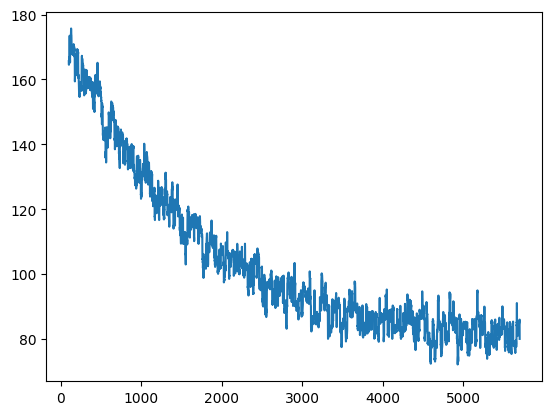

In [ ]:
# Apply My custom Linear Regression

loss_history = SGD(X_train, y_train, my_lm, mse, opt=opt, 
                   batch_size=10, 
                   n_epochs=150)


my_preds = my_lm.predict(X_test)
base_mse_score = mse.compute(my_preds, y_test)
base_r2_score = r2_score(y_test, base_preds)

print(f"My model mse = {base_mse_score}, r2 = {base_r2_score}")

smoothed_loss_history = [np.mean(loss_history[step - 100: step]) for step in range(len(loss_history))]
plt.plot(smoothed_loss_history)
plt.show()

# Logistic Regression

In [15]:
def plot_roc_curve(y_target, y_pred_prob):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob) 
    plt.figure()  
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

In [17]:
# Load dataset split and apply scaler

X, y = load_breast_cancer(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                      test_size=0.20,
                                      random_state=23)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape

((455, 30), (114, 30))

In [ ]:
# Apply sklearn model

clf = LogisticRegression(fit_intercept=False)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Sklearn Logistic Regression model accuracy = {acc * 100:.1f}%")

Sklearn Logistic Regression model accuracy = 98.2%


In [22]:
# Init my logistic regression, optimizer and loss function

my_clf = LogisticRegressionBC(30)

opt = Adam()
opt.set_learning_params(my_clf.weights)

ce_loss = CrossEntropyLoss()


My Logistic Regression model accuracy = 98.245614%


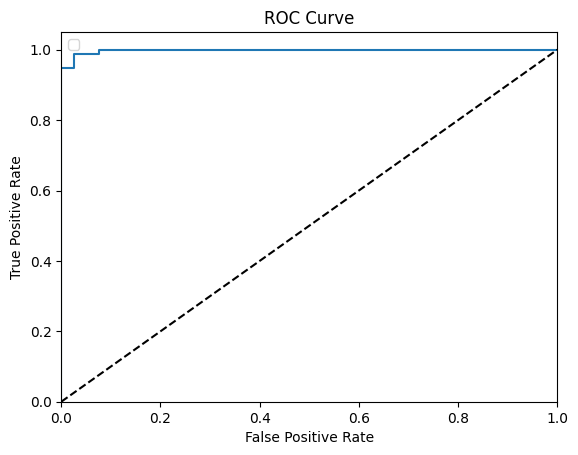

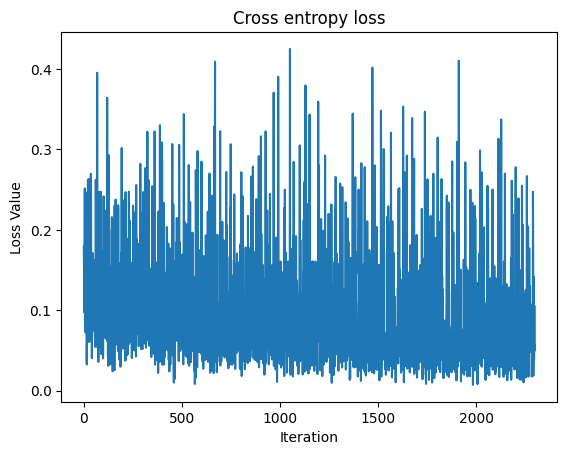

In [24]:
loss_history = SGD(X_train, y_train, my_clf, ce_loss, opt=opt, 
                      batch_size=20, 
                      n_epochs=100
                  )


probas = my_clf.predict(X_test)
my_preds = probas > 0.5
accuracy = accuracy_score(y_test, my_preds)

print(f"My Logistic Regression model accuracy = {accuracy * 100:1f}%")

plot_roc_curve(y_test, probas)

plt.plot(loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss Value")
plt.title("Cross entropy loss")
plt.show()